# 第7章 方差分析(Analysis of Variance,ANOVA)

## 7.1方差分析的基本原理

>比较两个样本的方差是否相等，用F统计量
$$F=\frac{S_1^2}{S_2^2}$$

## 7.2 一元方差分析(one way ANOVA)

### 7.2.1 一元单因素方差分析

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

In [2]:
path=r"D:\文档\Python Scripts\Python数据分析基础（第2版）数据\ch7\dc_sales.csv"
data=pd.read_csv(path)
print(data.head())
data['pixel']=data['pixel'].astype('category')
data['pixel'].cat.categories=['<500','500-600','600-800','800-1000','>1000']
print(pd.pivot_table(data,index='pixel',columns='market',values='sales'))


   market  pixel  sales
0       1      1     70
1       1      2    101
2       1      3    114
3       1      4    120
4       1      5    132
market      1    2    3    4    5    6    7    8
pixel                                           
<500       70   67   82   87   80   80   87   96
500-600   101   76   97   88   92   99  123   90
600-800   114   96  128  103  107   91   99  119
800-1000  120   98  132  128  132  132  131  119
>1000     132  102  123  119  123  135  126  117


([<matplotlib.axis.XTick at 0x28c52bd2c18>,
 <a list of 6 Text xticklabel objects>)

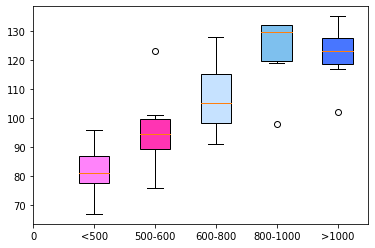

In [11]:
import matplotlib.pyplot as plt

g=data['pixel'].unique()
args=[]
for i in g:
    args.append(data[data['pixel']==i]['sales'])#获得每种像素销量的列表

#绘制盒须图
plot=plt.boxplot(args,vert=True,patch_artist=True)
color=['#FF83FA','#FF34B3','#C6E2FF','#7EC0EE','#4876FF']
for x,y in zip(plot['boxes'],color):
    x.set_facecolor(y)
plt.xticks(ticks=range(len(g)+1),labels=['0',*g])
plt.show()

#### 7.2.1.1 方差同质性检验

>对于一元方差分析采用Levene's检验,多元方差分析采用Bartlett's球形检验法

In [12]:
stats.levene(*args)#P值非常大，满足方差齐性假设

LeveneResult(statistic=0.233384556281214, pvalue=0.9176929576341715)

#### 7.2.1.2 方差来源分解以及检验过程

>scipy.stats的f_oneway函数可以进行一元单因素方差分析并直接得到最终结果

In [16]:
stats.f_oneway(*args)

F_onewayResult(statistic=19.57176228742291, pvalue=1.5491302153222814e-08)

使用statsmodels的anova_lm配合OLS函数得到更加详细的计算结果

In [13]:
from statsmodels.formula.api import ols

data_anova=sm.stats.anova_lm(ols('sales~C(pixel)',data).fit())
print(data_anova)


            df     sum_sq    mean_sq          F        PR(>F)
C(pixel)   4.0  10472.850  2618.2125  19.571762  1.549130e-08
Residual  35.0   4682.125   133.7750        NaN           NaN


#### 7.2.1.3 多重比较检验

>  进一步探究因素的哪一个水平对观察变量产生了显著影响,statsmodels.stats.multicomp中提供了pairwise_tukeyhsd函数可以进行TukeyHSD事后多重比较检验

In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data_anova_post=pairwise_tukeyhsd(data['sales'],data['pixel'],alpha=0.05)
print(data_anova_post)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
 500-600  600-800   11.375 0.3029  -5.2516  28.0016  False
 500-600 800-1000    28.25  0.001  11.6234  44.8766   True
 500-600     <500  -14.625 0.1072 -31.2516   2.0016  False
 500-600    >1000   26.375  0.001   9.7484  43.0016   True
 600-800 800-1000   16.875 0.0453   0.2484  33.5016   True
 600-800     <500    -26.0  0.001 -42.6266  -9.3734   True
 600-800    >1000     15.0 0.0934  -1.6266  31.6266  False
800-1000     <500  -42.875  0.001 -59.5016 -26.2484   True
800-1000    >1000   -1.875    0.9 -18.5016  14.7516  False
    <500    >1000     41.0  0.001  24.3734  57.6266   True
----------------------------------------------------------


#### 7.2.1.4 方差分析模型的参数估计和预测

In [15]:
formula='sales~C(pixel)'
data_est=ols(formula,data).fit()
print(data_est.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     19.57
Date:                Sat, 09 Nov 2019   Prob (F-statistic):           1.55e-08
Time:                        20:57:33   Log-Likelihood:                -152.01
No. Observations:                  40   AIC:                             314.0
Df Residuals:                      35   BIC:                             322.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               81.1250 

#### 7.2.1.5方差分析模型的预测

>对statsmodels的模型对象使用fittedvalues属性就可以直接依据模型参数估计结果对因变量进行预测

In [17]:
data_est.fittedvalues
#使用模型对象的get_influence得到更加详细的预测信息
sales_influence=data_est.get_influence()
sales_influence.summary_table()

0      81.125
1      95.750
2     107.125
3     124.000
4     122.125
5      81.125
6      95.750
7     107.125
8     124.000
9     122.125
10     81.125
11     95.750
12    107.125
13    124.000
14    122.125
15     81.125
16     95.750
17    107.125
18    124.000
19    122.125
20     81.125
21     95.750
22    107.125
23    124.000
24    122.125
25     81.125
26     95.750
27    107.125
28    124.000
29    122.125
30     81.125
31     95.750
32    107.125
33    124.000
34    122.125
35     81.125
36     95.750
37    107.125
38    124.000
39    122.125
dtype: float64

obs,endog,fitted,Cook's,student.,hat diag,dffits,ext.stud.,dffits
,,value,d,residual,,internal,residual,
0.0,70.0,81.125,0.03020987875621187,-1.0282731915534002,0.12499999999999996,-0.3886507349549971,-1.0291414533361096,-0.38897890706213284
1.0,101.0,95.74999999999994,0.0067277144458981085,0.48525251736228403,0.12500000000000003,0.18340821200123658,0.47988709866950074,0.1813802743525449
2.0,114.0,107.125,0.011537038661474689,0.6354497251172698,0.12500000000000008,0.24017742047780727,0.6299505105573793,0.23809891274471356
3.0,120.0,123.99999999999994,0.0039054306080494997,-0.36971620370458813,0.12499999999999999,-0.13973959009617676,-0.365109921937426,-0.13799857923551928
4.0,132.0,122.125,0.02380253166488049,0.9127368778957149,0.12499999999999999,0.34498211304994125,0.9105047080607075,0.34413843215458556
5.0,67.0,81.125,0.04869965179119675,-1.3055603443318453,0.12499999999999997,-0.4934554275271311,-1.319299988481735,-0.49864852488757844
6.0,76.0,95.74999999999994,0.0952101266595214,-1.8254737557914245,0.125,-0.6899642260998804,-1.8915035659173784,-0.714921148487036
7.0,96.0,107.125,0.030209878756211884,-1.0282731915534002,0.12500000000000003,-0.38865073495499713,-1.0291414533361098,-0.388978907062133
8.0,98.0,123.99999999999994,0.16500444319009533,-2.4031553240798518,0.12499999999999999,-0.9083073356251598,-2.5920608685832773,-0.9797069202019182


### 7.2.2 一元多因素方差分析
#### 7.2.2.1 只考虑主效应的多因素方差分析

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [4]:
path=r'D:\文档\Python Scripts\Python数据分析基础（第2版）数据\ch7\house.csv'
house=pd.read_csv(path)
house.head()
education=['初中及以下','高中','大学','研究生及以上']
unit=['国营企业','行政事业单位','大专院校科研单位','私营企业','失业','其他']
type_=['一室一厅','二室一厅','二室二厅','三室一厅','三室二厅','三室三厅','四室二厅一卫','四室二厅二卫','四室三厅一卫','四室三厅二卫','更大']
income=['<10000','10000-25000','25000-50000','50000-75000','>75000']
house.education=house.education.astype('category')
house.education.cat.categories=education
house.unit=house.unit.astype('category')
house.unit.cat.categories=unit
house.type=house.type.astype('category')
house.type.cat.categories=type_
house.income=house.income.astype('category')
house.income.cat.categories=income
house.head()

,education,unit,income,type,space
0,1,3,2,2,75.0
1,1,5,1,6,55.0
2,3,1,2,8,56.0
3,2,6,2,4,51.0
4,2,4,1,5,60.0


,education,unit,income,type,space
0,初中及以下,大专院校科研单位,10000-25000,二室一厅,75.0
1,初中及以下,失业,<10000,三室三厅,55.0
2,大学,国营企业,10000-25000,四室二厅二卫,56.0
3,高中,其他,10000-25000,三室一厅,51.0
4,高中,私营企业,<10000,三室二厅,60.0


In [7]:
formula='space~C(education)+C(unit)+C(income)+C(type)'
house_anova=sm.stats.anova_lm(ols(formula,data=house).fit(),typ=3)
house_anova

,sum_sq,df,F,PR(>F)
Intercept,28663.946440,1.0,89.701281,1.591592e-19
C(education),1519.401986,3.0,1.584945,1.922550e-01
C(unit),886.371451,5.0,0.554764,7.347011e-01
C(income),10545.816026,4.0,8.250549,1.990132e-06
C(type),9604.428837,10.0,3.005621,1.093296e-03
Residual,143477.460152,449.0,NaN,NaN


多重比较检验

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [10]:
house_anova_post=pairwise_tukeyhsd(house['space'],house['income'],alpha=0.05)
house_anova_post.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
10000-25000,25000-50000,7.6175,0.0042,1.7029,13.5321,True
10000-25000,50000-75000,12.1263,0.1151,-1.665,25.9176,False
10000-25000,<10000,-4.6062,0.1992,-10.4621,1.2497,False
10000-25000,>75000,31.2777,0.001,15.812,46.7435,True
25000-50000,50000-75000,4.5088,0.9,-9.7758,18.7933,False
25000-50000,<10000,-12.2238,0.001,-19.1621,-5.2854,True
25000-50000,>75000,23.6602,0.001,7.753,39.5674,True
50000-75000,<10000,-16.7325,0.0122,-30.9929,-2.4722,True
50000-75000,>75000,19.1514,0.073,-1.0539,39.3567,False
<10000,>75000,35.884,0.001,19.9985,51.7694,True


OLS回归

In [17]:
formula='space~C(income)+C(type)-1'
ols(formula,house).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                 OLS                Adj. R-squared:       0.146    
Dependent Variable:    space              AIC:                  4076.2755
Date:                  2019-11-10 12:17   BIC:                  4138.6302
No. Observations:      472                Log-Likelihood:       -2023.1  
Df Model:              14                 F-statistic:          6.752    
Df Residuals:          457                Prob (F-statistic):   1.38e-12 
R-squared:             0.171              Scale:                319.59   
-------------------------------------------------------------------------
                        Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-------------------------------------------------------------------------
C(income)[<10000]       86.1464   9.0005  9.5713 0.0000  68.4589 103.8339
C(income)[10000-25000]  90.3536   9.0005 10.0387 0.0000  72.6661 108.0411
C(income)[25000-50000]  96.1065   9.1886 10.4593 0.0000  78.0492 114.1637
C(income)[50000-75000] 102.2754  10.2017 10.0253 0.0000  82.2273 122.3236
C(income)[>75000]      115.4981  10.6282 10.8671 0.0000  94.6119 136.3844
C(type)[T.二室一厅]        -23.0808   9.1696 -2.5171 0.0122 -41.1005  -5.0610
C(type)[T.二室二厅]        -22.5007   9.2538 -2.4315 0.0154 -40.6859  -4.3155
C(type)[T.三室一厅]        -23.0634   9.1100 -2.5317 0.0117 -40.9660  -5.1608
C(type)[T.三室二厅]        -19.4782   9.0933 -2.1420 0.0327 -37.3481  -1.6083
C(type)[T.三室三厅]        -28.6264  15.5200 -1.8445 0.0658 -59.1259   1.8730
C(type)[T.四室二厅一卫]       -7.2395  10.1864 -0.7107 0.4776 -27.2575  12.7784
C(type)[T.四室二厅二卫]      -12.6134   9.5902 -1.3152 0.1891 -31.4598   6.2329
C(type)[T.四室三厅一卫]      -38.3536  20.0149 -1.9162 0.0560 -77.6864   0.9791
C(type)[T.四室三厅二卫]      -26.4948  12.0484 -2.1990 0.0284 -50.1719  -2.8176
C(type)[T.更大]           -4.5995  10.5095 -0.4377 0.6618 -25.2524  16.0533
-------------------------------------------------------------------------
Omnibus:                 88.385         Durbin-Watson:            1.372  
Prob(Omnibus):           0.000          Jarque-Bera (JB):         157.668
Skew:                    1.083          Prob(JB):                 0.000  
Kurtosis:                4.825          Condition No.:            35     
=========================================================================

"""

#### 7.2.2.2 存在交互效应的多因素方差分析

In [22]:
formula='space~C(income)*C(type)'
fit=ols(formula,house).fit()
sm.stats.anova_lm(fit)#方差分析结果
fit.rsquared

,df,sum_sq,mean_sq,F,PR(>F)
C(income),4.0,19655.107559,4913.776890,16.629186,1.077135e-12
C(type),10.0,10553.485226,1055.348523,3.571507,1.438294e-04
C(income):C(type),40.0,19729.421811,493.235545,1.669206,7.857478e-03
Residual,436.0,128834.132740,295.491130,NaN,NaN


0.26907101524187094

## 7.3 协方差分析

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [24]:
path=r'D:\文档\Python Scripts\Python数据分析基础（第2版）数据\ch7\sale_points.csv'
sale=pd.read_csv(path)
sale.head()

,market,warranty,sales,points
0,1,1,26.0,1.8
1,1,1,22.0,1.1
2,1,1,21.8,0.9
3,1,1,33.1,2.2
4,2,1,22.0,2.0


In [28]:
formula='sales~points+C(market)*C(warranty)'
sm.stats.anova_lm(ols(formula,data=sale).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(market),2.0,593.160833,296.580417,56.984051,2.903413e-08
C(warranty),1.0,512.450417,512.450417,98.460650,1.734504e-08
C(market):C(warranty),2.0,167.155833,83.577917,16.058404,1.211601e-04
points,1.0,196.523934,196.523934,37.759505,1.079351e-05
Residual,17.0,88.478566,5.204622,NaN,NaN


In [29]:
ols(formula,data=sale).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                   OLS                   Adj. R-squared:          0.923   
Dependent Variable:      sales                 AIC:                     113.4220
Date:                    2019-11-10 12:32      BIC:                     121.6684
No. Observations:        24                    Log-Likelihood:          -49.711 
Df Model:                6                     F-statistic:             47.05   
Df Residuals:            17                    Prob (F-statistic):      1.16e-09
R-squared:               0.943                 Scale:                   5.2046  
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
--------------------------------------------------------------------------------
Intercept                       12.8441   2.3865  5.3821 0.0000   7.8091 17.8791
C(market)[T.2]                  -8.0349   1.7073 -4.7063 0.0002 -11.6369 -4.4329
C(market)[T.3]                   1.3456   1.6147  0.8334 0.4162  -2.0610  4.7523
C(warranty)[T.2]                 3.0485   1.6731  1.8221 0.0861  -0.4813  6.5784
C(market)[T.2]:C(warranty)[T.2]  5.4217   2.4781  2.1878 0.0429   0.1933 10.6501
C(market)[T.3]:C(warranty)[T.2] 14.0594   2.3377  6.0142 0.0000   9.1273 18.9914
points                           8.5873   1.3975  6.1449 0.0000   5.6389 11.5357
--------------------------------------------------------------------------------
Omnibus:                    0.619             Durbin-Watson:               3.022
Prob(Omnibus):              0.734             Jarque-Bera (JB):            0.690
Skew:                       -0.305            Prob(JB):                    0.708
Kurtosis:                   2.435             Condition No.:               17   
================================================================================

"""